In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
ticker = "AAPL"  # Example: Apple stock
df = yf.download(ticker, start="2020-01-01", end="2025-01-01")
df = df[['Close']]  # Focus on closing prices
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2020-01-02,72.716080
2020-01-03,72.009117
2020-01-06,72.582916
2020-01-07,72.241554
2020-01-08,73.403656


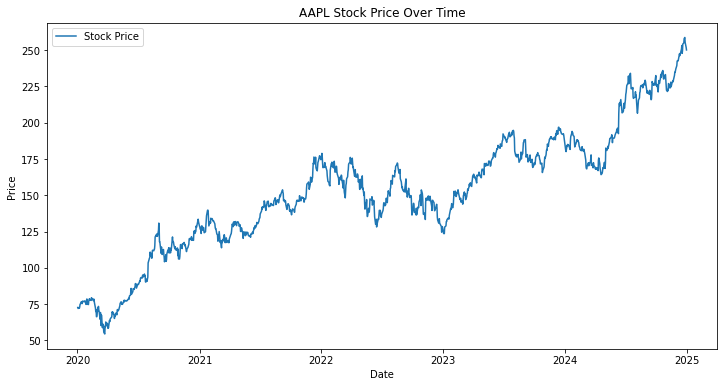

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Stock Price')
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [4]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The data is stationary (reject H0)")
    else:
        print("The data is not stationary (fail to reject H0)")

adf_test(df['Close'])

ADF Statistic: -0.7084056621760588
p-value: 0.8445602513360551
The data is not stationary (fail to reject H0)


ADF Statistic: -35.93871111271929
p-value: 0.0
The data is stationary (reject H0)


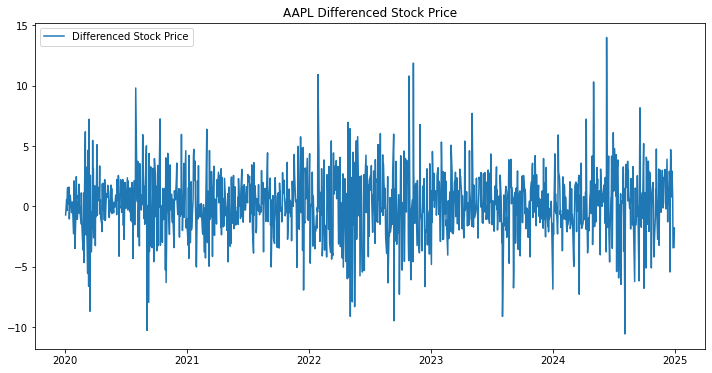

In [5]:
df['Close_diff'] = df['Close'].diff()
adf_test(df['Close_diff'].dropna())

plt.figure(figsize=(12,6))
plt.plot(df['Close_diff'], label='Differenced Stock Price')
plt.title(f"{ticker} Differenced Stock Price")
plt.legend()
plt.show()

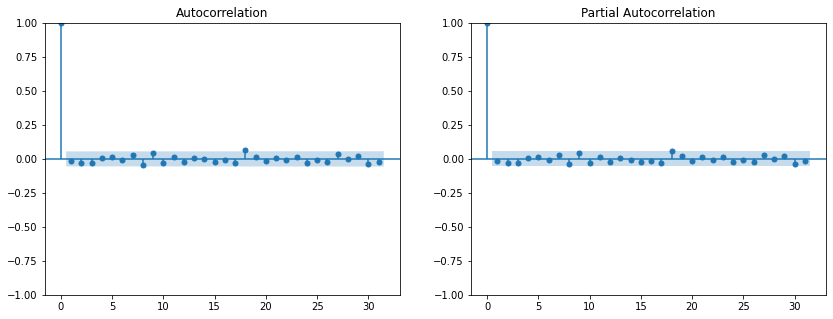

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df['Close_diff'].dropna(), ax=axes[0])
plot_pacf(df['Close_diff'].dropna(), ax=axes[1])
plt.show()

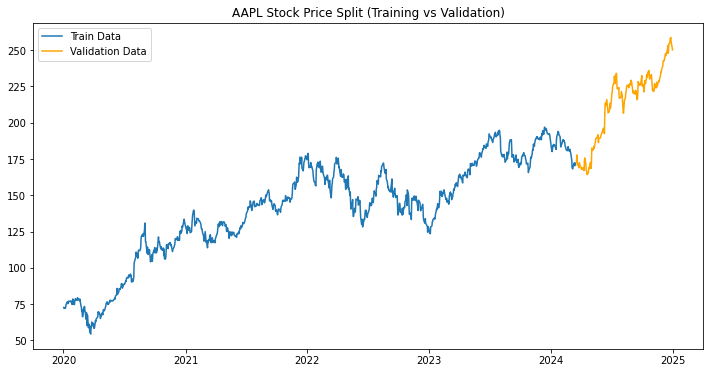

In [7]:
train_size = len(df) - 200  # Last 100 days for validation
train, valid = df.iloc[:train_size], df.iloc[train_size:]

plt.figure(figsize=(12,6))
plt.plot(train['Close'], label='Train Data')
plt.plot(valid['Close'], label='Validation Data', color='orange')
plt.title(f"{ticker} Stock Price Split (Training vs Validation)")
plt.legend()
plt.show()

In [8]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 1,1,1 # Adjust these based on ACF/PACF analysis
model = ARIMA(train['Close'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1058
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2503.500
Date:                Sun, 16 Feb 2025   AIC                           5013.000
Time:                        17:44:29   BIC                           5027.890
Sample:                             0   HQIC                          5018.644
                               - 1058                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4998      0.593      0.843      0.399      -0.662       1.662
ma.L1         -0.5286      0.584     -0.904      0.366      -1.674       0.617
sigma2         6.6799      0.220     30.405      0.0

c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
from pmdarima import auto_arima

auto_model = auto_arima(df['Close'], seasonal=True, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6037.686, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6031.740, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6033.460, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6033.444, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6033.271, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6034.554, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.970 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3013.870
Date:                Sun, 16 Feb 2025   AIC                           6031.740
Time:                        17:44:32   BIC                           6042.013
Sample:                             0   HQIC                          6035.601
          

In [31]:
future_steps = 200
forecast = model_fit.get_forecast(steps=future_steps)  # Correct method
forecast_ci = forecast.conf_int()  # Confidence intervals

# Generate forecast dates
forecast_index = pd.date_range(start=train.index[-1], periods=future_steps+1, freq="B")[1:]



c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ogo13\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [32]:
forecast.predicted_mean

1058    171.801290
1059    171.797570
1060    171.795711
1061    171.794782
1062    171.794318
           ...    
1253    171.793854
1254    171.793854
1255    171.793854
1256    171.793854
1257    171.793854
Name: predicted_mean, Length: 200, dtype: float64

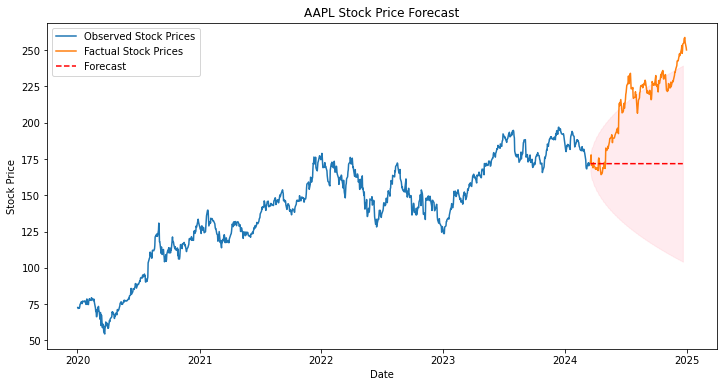

In [33]:
# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(train["Close"], label="Observed Stock Prices")
plt.plot(valid["Close"], label="Factual Stock Prices")
plt.plot(forecast_index, forecast.predicted_mean, label="Forecast", color="red", linestyle="--")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="pink", alpha=0.3)

# Labels and title
plt.title(f"{ticker} Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [34]:
print(forecast.predicted_mean)

1058    171.801290
1059    171.797570
1060    171.795711
1061    171.794782
1062    171.794318
           ...    
1253    171.793854
1254    171.793854
1255    171.793854
1256    171.793854
1257    171.793854
Name: predicted_mean, Length: 200, dtype: float64
